In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
data_path = '../../data/postprocessed/PM/'

mapping_table = {
    'backprop': 'Backpropagation algorithm',
    'gaussian': 'Gaussian Elimination',
    'gpu': 'Stream Cluster',
    'lenet': 'Lenet5',
    'gpuburn': 'GPU-burn'
}

data_sheet = pd.DataFrame()
for csv_name in [file for file in os.listdir(data_path) if not file.endswith('_telemetry.csv') and not file.startswith('srad')]:
    csv_full_path = os.path.join(data_path, csv_name)
    # print(csv_full_path)
    df = pd.read_csv(csv_full_path)
    df['Range'] = int(csv_name.split('_')[1].split('.')[0])
    df['App_name'] = mapping_table[csv_name.split('_')[0]]

    data_sheet=pd.concat([data_sheet, df], ignore_index=True)

## Fixing the set of computed metrics across all the experiments

### I want to check if the number of Kernel Injection (Range) affects the number of run sessions.

In [3]:
for label in sorted(data_sheet['Range'].unique()):
    print("--------------------------------------------------------------------")
    print(f'Number of times a kernel is executed for metric computation: {label}') 
    print(f"Instances: {len(data_sheet[data_sheet['Range']==label])}")

--------------------------------------------------------------------
Number of times a kernel is executed for metric computation: 1
Instances: 33756
--------------------------------------------------------------------
Number of times a kernel is executed for metric computation: 10
Instances: 34080
--------------------------------------------------------------------
Number of times a kernel is executed for metric computation: 20
Instances: 34224
--------------------------------------------------------------------
Number of times a kernel is executed for metric computation: 30
Instances: 34248
--------------------------------------------------------------------
Number of times a kernel is executed for metric computation: 50
Instances: 34260
--------------------------------------------------------------------
Number of times a kernel is executed for metric computation: 80
Instances: 34296
--------------------------------------------------------------------
Number of times a kernel is exec

### Apparently not

### Thus, it must be dependent only on the application complexity

In [4]:
for label in mapping_table.values():
    print("--------------------------------------------------------------------")
    print(f'App name: {label}') 
    print(f"Instances: {len(data_sheet[data_sheet['App_name']==label])}")

--------------------------------------------------------------------
App name: Backpropagation algorithm
Instances: 168
--------------------------------------------------------------------
App name: Gaussian Elimination
Instances: 171864
--------------------------------------------------------------------
App name: Stream Cluster
Instances: 0
--------------------------------------------------------------------
App name: Lenet5
Instances: 45792
--------------------------------------------------------------------
App name: GPU-burn
Instances: 21348


### Considerations
1. Complexity does not imply stress
2. I think that the complexity is due also to the number of kernels that the application comprises

TODO: look at Future works

### Available data

In [5]:
location_mapping={
    'gpc': 'GPU Processing Cluster',
    'gr': 'Graphics Engine',
    'sm': 'Streaming Multiprocessor',
    'dramc': 'Dynamic RAM Controller',
    'pcie': 'PCI Express'
}
data_sheet['location'].unique()

array(['gpc', 'gr', 'tpc', 'sm', 'dramc', 'pcie'], dtype=object)

In [6]:
data_sheet['HR_location'] = data_sheet['location'].map(location_mapping)
data_sheet.drop('location', axis=1, inplace=True)

In [7]:
len(data_sheet)
239172-19931

219241

In [8]:
metric_event_mapping= {
    'cycles_elapsed': 'Total elapsed cycles [Cycles/s]',
    'cycles_active': 'Active cycles [Cycles/s]',
    'warps_active_realtime': 'Active warps [%]',
    'inst_executed': 'Executed instructions [%]',
    'ipe_tensor_cycles_active':'Tensor Cores Active Cycles [%]',
    'sectors_op_read':'Read Sectors [%]',
    'sectors_op_wtite':'Written Sectors [%]',
    'read_bytes':'Read bytes (CPU to GPU) [%]',
    'write_bytes':'Written bytes (GPU to CPU) [%]',
}
data_sheet['metric_name'].unique()

# pcie metrics are computed in a different way and it is better to keep them as a percentace
data_sheet = data_sheet[~((data_sheet['rollup_operation'] == 'sum') & (data_sheet['metric_name'] == 'read_bytes'))]

In [9]:

# It is a useless column, we can drop it
data_sheet = data_sheet.drop('rollup_operation', axis=1)

In [10]:
data_sheet['HR_metric_name'] = data_sheet['metric_name'].map(metric_event_mapping)
data_sheet.drop('metric_name', axis=1, inplace=True)

### Let's fix for a second the Number of times a kernel is executed for metric computations to 1

In [11]:
data_sheet['Range'].dtypes

dtype('int64')

In [12]:
data_sheet_100 = data_sheet[data_sheet['Range']==100]

In [13]:
data_sheet['HR_metric_name'].unique()

array(['Total elapsed cycles [Cycles/s]', 'Active cycles [Cycles/s]',
       'Active warps [%]', 'Executed instructions [%]', nan,
       'Read Sectors [%]', 'Read bytes (CPU to GPU) [%]',
       'Written bytes (GPU to CPU) [%]'], dtype=object)

### Regardless of the application I want to see the correlation within the columns

In [14]:
df_l2_100 = data_sheet_100[data_sheet_100['HR_location']=='GPU Processing Cluster']
df_sm_100 = data_sheet_100[data_sheet_100['HR_location']=='Graphics Engine']
df_smsp_100 = data_sheet_100[data_sheet_100['HR_location']=='Streaming Multiprocessor']
df_sys_100 = data_sheet_100[data_sheet_100['HR_location']=='PCI Express']
df_dram_100 = data_sheet_100[data_sheet_100['HR_location']=='Dynamic RAM Controller']

dfs = {
    'GPU Processing Cluster': df_l2_100, 
    'Graphics Engine': df_sm_100, 
    'Streaming Multiprocessor': df_smsp_100, 
    'PCI Express': df_sys_100, 
    'Dynamic RAM Controller': df_dram_100
    }

In [15]:
df_pivot_l2_100 = df_l2_100.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_sm_100 = df_sm_100.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_smsp_100 = df_smsp_100.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_sys_100 = df_sys_100.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_dram_100 = df_dram_100.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

pivot_dfs = {
    'GPU Processing Cluster': df_pivot_l2_100, 
    'Graphics Engine': df_pivot_sm_100, 
    'Streaming Multiprocessor': df_pivot_smsp_100, 
    'PCI Express': df_pivot_sys_100, 
    'Dynamic RAM Controller': df_pivot_dram_100
    }

In [16]:
metric_full_name = data_sheet_100['HR_location'] +' '+ data_sheet_100['HR_metric_name']
metric_full_name

68592     GPU Processing Cluster Total elapsed cycles [C...
68593     GPU Processing Cluster Total elapsed cycles [C...
68594              Graphics Engine Active cycles [Cycles/s]
68595              Graphics Engine Active cycles [Cycles/s]
68596                                                   NaN
                                ...                        
232639           PCI Express Written bytes (GPU to CPU) [%]
232640           PCI Express Written bytes (GPU to CPU) [%]
232641           PCI Express Written bytes (GPU to CPU) [%]
232642           PCI Express Written bytes (GPU to CPU) [%]
232643           PCI Express Written bytes (GPU to CPU) [%]
Length: 31449, dtype: object

/home/bepi/anaconda3/envs/gpustress/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/bepi/anaconda3/envs/gpustress/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


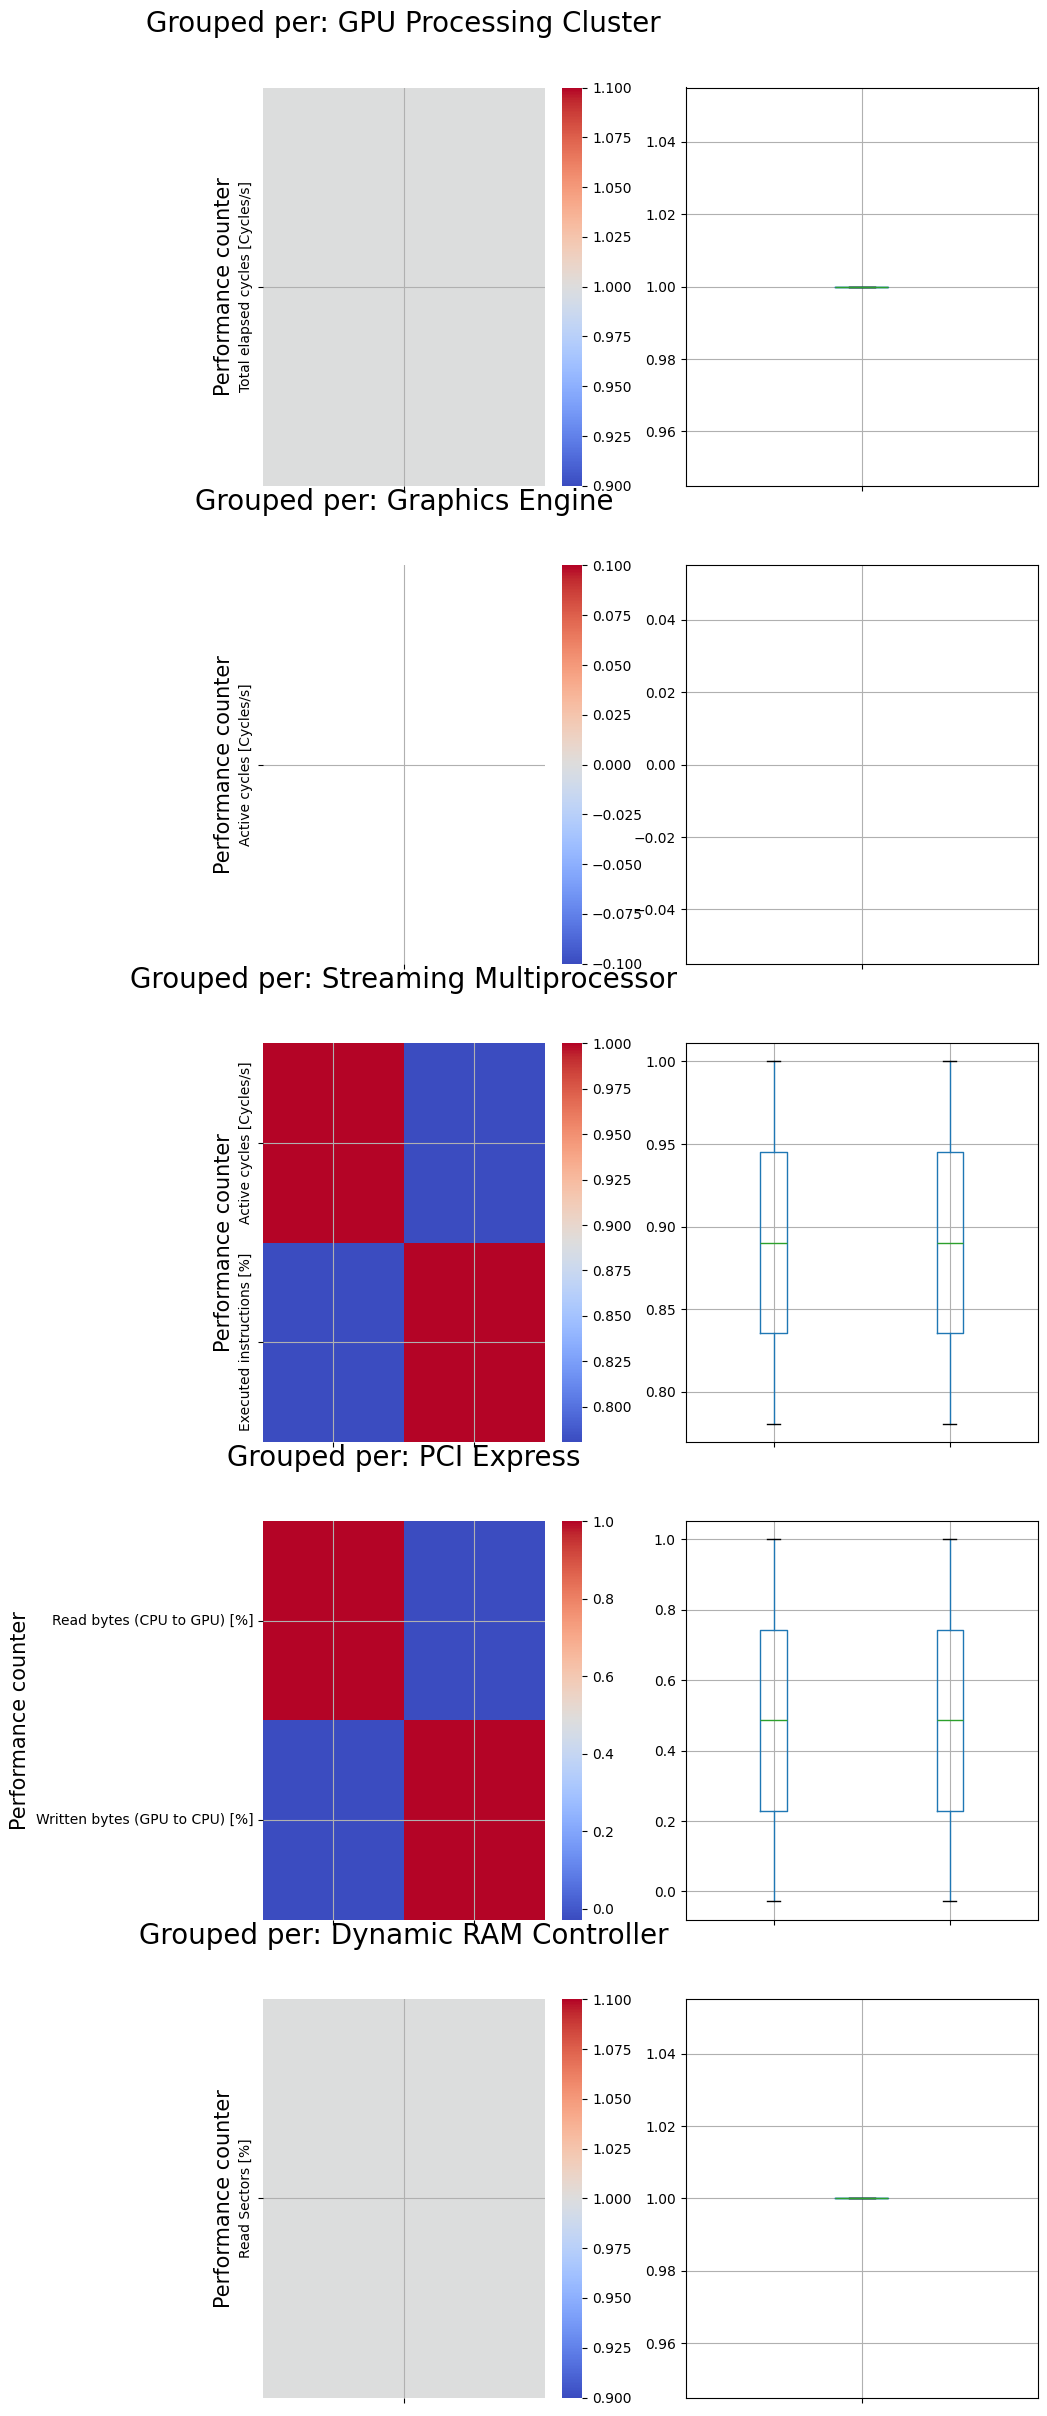

In [17]:
fig, ax = plt.subplots(5,2,figsize=(10,30))
for pivot_df_idx in range(len(list(pivot_dfs.values()))):
    HR_location = list(pivot_dfs.keys())[pivot_df_idx]
    # print(pivot_dfs[HR_location].select_dtypes(include=['float64']))
    # data_to_corr = pivot_dfs[HR_location][cols_to_corr]
    # target_data = data_to_corr.drop('HR_location', axis = 1)
    data_to_corr = pivot_dfs[HR_location].select_dtypes(include=['float64'])
    matrix = data_to_corr.corr()
    matrix.boxplot(ax=ax[pivot_df_idx][1])
    sns.heatmap(matrix, annot=False, cmap='coolwarm', ax=ax[pivot_df_idx][0])
    ax[pivot_df_idx][0].set_title(f"Grouped per: {HR_location}", fontsize=20, pad=40)
    ax[pivot_df_idx][0].grid()
    ax[pivot_df_idx][0].set_xlabel('Performance counter', fontsize=15)
    ax[pivot_df_idx][0].set_ylabel('Performance counter', fontsize=15)
    ax[pivot_df_idx][1].tick_params(axis='x', labelrotation=90, labelsize=13)
    ax[pivot_df_idx][0].tick_params(axis='x', labelrotation=90, labelsize=13)
    ax[pivot_df_idx][0].set_xticklabels([])
    ax[pivot_df_idx][1].set_xticklabels([])
    ax[pivot_df_idx][0].set_xlabel('')

### Stress evaluation

In [18]:
hue_order = ['Backpropagation algorithm', 'Gaussian Elimination', 'Lenet5', 'GPU-burn']

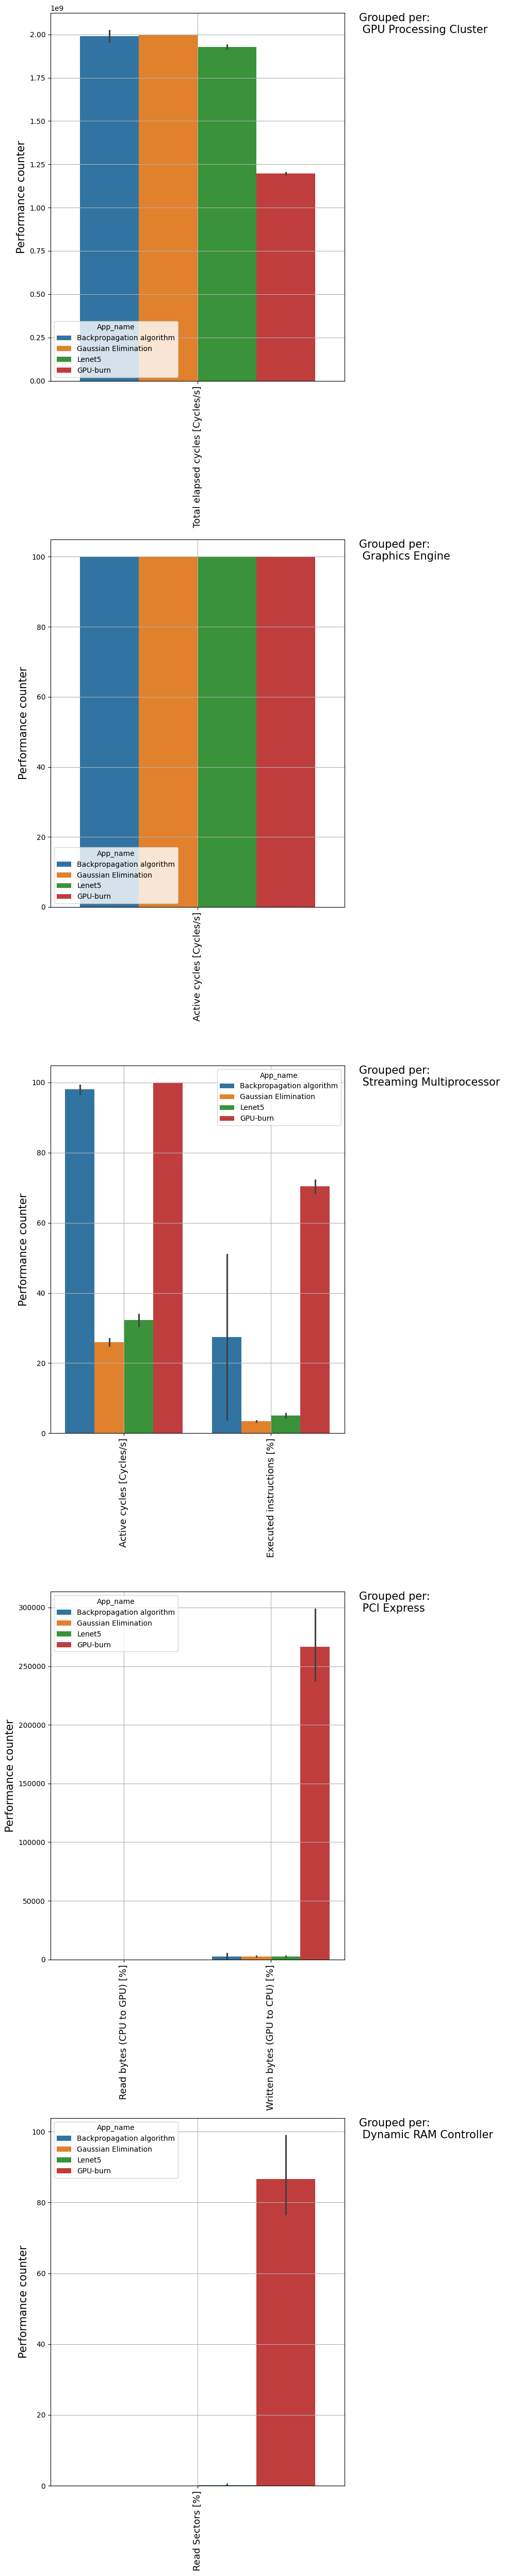

In [19]:
fig, ax = plt.subplots(5,1,figsize=(10,50))
for pivot_df_idx in range(len(list(dfs.values()))):
    HR_location = list(dfs.keys())[pivot_df_idx]
    # data_to_corr = dfs[HR_location].select_dtypes(include=['float64'])
    sns.barplot(data = dfs[HR_location], x='HR_metric_name', y='metric_value', hue='App_name', ax = ax[pivot_df_idx], hue_order=hue_order)
    # ax[pivot_df_idx].set_title(f"Grouped per: {HR_location}", fontsize=20, loc='right')
    ax[pivot_df_idx].text(1.05, 1.0, f'Grouped per: \n {HR_location}', transform=ax[pivot_df_idx].transAxes,
         ha='left', va='top', fontsize=15)
    ax[pivot_df_idx].grid()
    # ax[pivot_df_idx].set_yscale('log')
    ax[pivot_df_idx].set_xlabel('Performance counter', fontsize=15)
    ax[pivot_df_idx].set_ylabel('Performance counter', fontsize=15)
    ax[pivot_df_idx].tick_params(axis='x', labelrotation=90, labelsize=13)
    # ax[pivot_df_idx].set_xticklabels([])
    ax[pivot_df_idx].set_xlabel('')
plt.tight_layout()

/tmp/ipykernel_31178/2907443675.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='session_id', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False, hue_order=hue_order)
/tmp/ipykernel_31178/2907443675.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='session_id', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False, hue_order=hue_order)
/tmp/ipykernel_31178/2907443675.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='session_id', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False, hue_order=hue_order)
/tmp/ipykernel_31178/2907443675.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='session_id', y='met

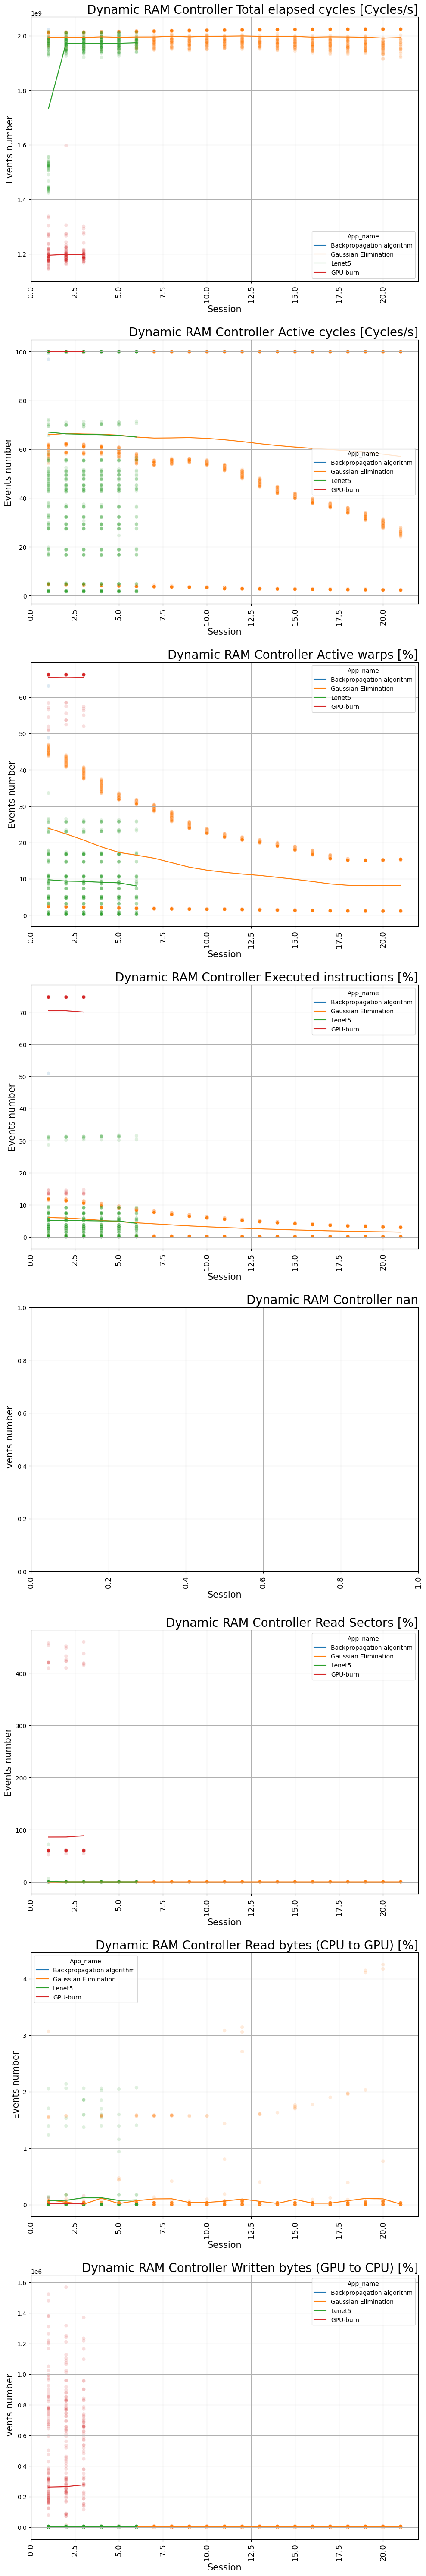

In [20]:
fig, ax = plt.subplots(8,1,figsize=(10,60))
for metric_idx in range(len(data_sheet_100['HR_metric_name'].unique())):
    metric_name = data_sheet_100['HR_metric_name'].unique()[metric_idx]
    data = data_sheet_100[data_sheet_100['HR_metric_name'] == metric_name]
    # HR_location=data['HR_location'].unique()[0]
    sns.lineplot(data = data, x='session_id', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False, hue_order=hue_order)
    sns.scatterplot(data = data, x='session_id', y='metric_value', hue='App_name', ax = ax[metric_idx], alpha=0.15, legend=False, hue_order=hue_order)
    ax[metric_idx].set_title(f"{HR_location} {metric_name}", fontsize=20, loc='right')
    # ax[metric_idx].text(1.05, 1.0, f'Grouped per: \n {HR_location}', transform=ax[metric_idx].transAxes,
    #      ha='left', va='top', fontsize=15)
    ax[metric_idx].grid()
    # ax[metric_idx].set_yscale('log')
    ax[metric_idx].set_xlabel('Session', fontsize=15)
    ax[metric_idx].set_ylabel('Events number', fontsize=15)
    ax[metric_idx].tick_params(axis='x', labelrotation=90, labelsize=13)
    # ax[df_idx].set_xticklabels([])
plt.tight_layout()

Text(0.5, 0, '')

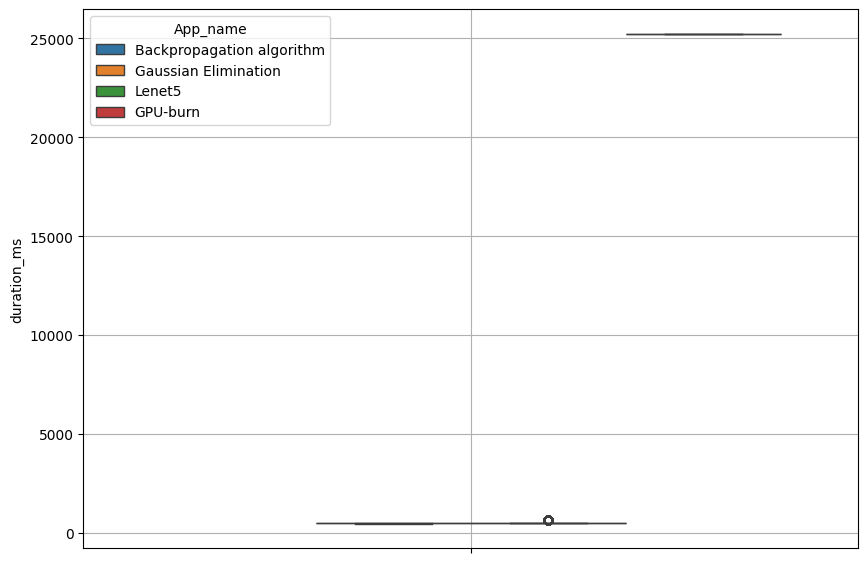

In [21]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
HR_location=data['HR_location'].unique()[0]
sns.boxplot(data, y='duration_ms', hue='App_name', ax = ax, hue_order=hue_order)
ax.grid()
ax.set_xlabel('', fontsize=15)

Text(0.5, 0, '')

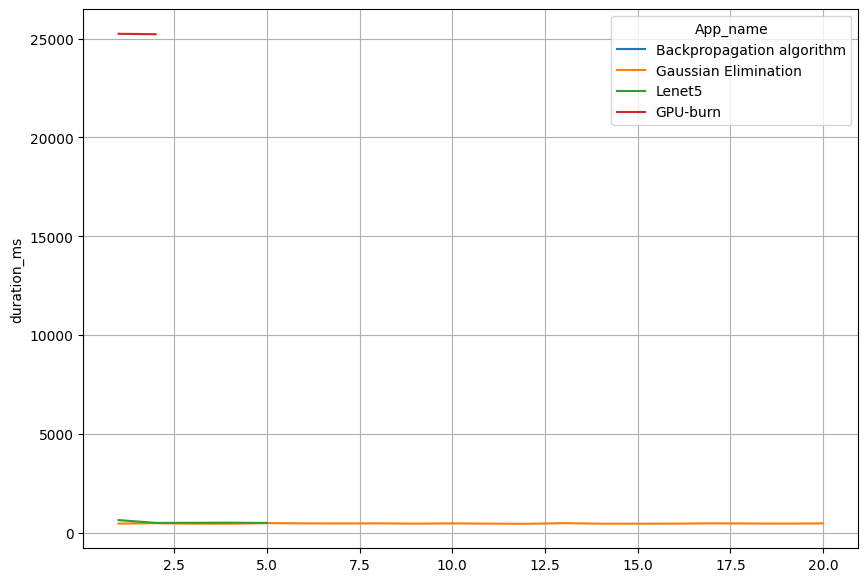

In [22]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
HR_location=data['HR_location'].unique()[0]
sns.lineplot(data, x='session_id' ,y='duration_ms', hue='App_name', ax = ax, hue_order=hue_order)
ax.grid()
ax.set_xlabel('', fontsize=15)

### Final remarks

### Future works
1. Use the correlation ID to correlate instructions with SASS code 
2. Explore the possibility to use sass_source_map or sass_metrics
3. 